In [10]:
import pandas as pd
import sys
import numpy as np
from matplotlib import pyplot as plot
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim.downloader
glove = gensim.downloader.load('glove-twitter-200')

[==================================================] 100.0% 758.5/758.5MB downloaded


In [11]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
df1 = pd.read_csv("/content/drive/MyDrive/for_train.txt", sep="\t", header=None, names=["text", "rephrase"])
print(df1.head())
df = df1


                                                text  \
0  You may be stressed out, but your body doesn't...   
1  Arghhh can't stand when tan goes patchy then i...   
2  M4&M49 were bloody horrendous. Finally found m...   
3  Life is just hard and harder when difficult pe...   
4  I realize you're all trying to help me, but it...   

                                            rephrase  
0  I will be able to go through stress because I ...  
1  Tanning can sometimes have unexpected results ...  
2  Even though I am facing a hard time at least I...  
3  Keep difficult people out of your life or you'...  
4  I am happy to have people who care about me an...  


In [13]:
len(df)
#all_texts = df["text"] + df["rephrase"]
all_texts = df["text"]
all_texts =all_texts.append(df["rephrase"])

<ipython-input-13-2aa0f4d9e1b8>:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_texts =all_texts.append(df["rephrase"])


In [14]:
len(all_texts)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_texts)
sequences = tokenizer.texts_to_sequences(all_texts)
max_seq_length = max(len(seq) for seq in sequences)
print(max_seq_length)

59


In [15]:
corpus_vec = []
def getVectors(dataset):

    for sentence in dataset:
        sent_vector = []
        count = 0;
        for word in sentence:
            count = count + 1;
            if (word in glove):
                vector = glove[word];
                sent_vector.append(np.array(vector))
        print("word", count)
        print(len(sent_vector))
        corpus_vec.append(sent_vector)
    return corpus_vec

In [16]:
cleaned_text = np.array(df['text'])
cleaned_rephrase= np.array(df['rephrase'])


short_text = []
short_summary = []

# filters out articles and summaries that are too long. this is where improvement
# could be made to include longer articles and just cut them off
for i in range(len(cleaned_text)):
    if len(cleaned_rephrase[i].split()) <= max_seq_length and len(cleaned_text[i].split()) <= max_seq_length:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_rephrase[i])

post_pre = pd.DataFrame({'text': short_text,'rephrase': short_summary})

# Add tokens labeled 'rbegin' and 'rend' to guide autoencoder through its
# rephrase generation
post_pre['rephrase'] = post_pre['rephrase'].apply(lambda x: 'rbegin ' + x + ' rend')

post_pre.head(5)

,text,rephrase
0,"You may be stressed out, but your body doesn't...",rbegin I will be able to go through stress bec...
1,Arghhh can't stand when tan goes patchy then i...,rbegin Tanning can sometimes have unexpected r...
2,M4&M49 were bloody horrendous. Finally found m...,rbegin Even though I am facing a hard time at ...
3,Life is just hard and harder when difficult pe...,rbegin Keep difficult people out of your life ...
4,"I realize you're all trying to help me, but it...",rbegin I am happy to have people who care abou...


In [17]:
tokenizer = Tokenizer()
all_texts1 = post_pre["text"]
all_texts1 =all_texts1.append(post_pre["rephrase"])
tokenizer.fit_on_texts(all_texts1)
sequences = tokenizer.texts_to_sequences(all_texts1)
max_seq_length = max(len(seq) for seq in sequences)
print(max_seq_length)

<ipython-input-17-d10a33ba6289>:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_texts1 =all_texts1.append(post_pre["rephrase"])


59


In [29]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(post_pre["text"]),
    np.array(post_pre["rephrase"]),
    test_size=0.2,
    random_state=0,
    shuffle=True,
)


In [31]:
text_sent_length = []
x_word_set = []
rephrase_sent_length = []
y_word_set = []
for i in df['text']:
      text_sent_length.append(len(i.split()))
      x_word_set.extend(i.split())
for j in df['rephrase']:
      rephrase_sent_length.append(len(j.split()))
      y_word_set.extend(j.split())

In [32]:
x_vocab = pd.Series(x_word_set).drop_duplicates().tolist()
y_vocab = pd.Series(y_word_set).drop_duplicates().tolist()
print(len(x_vocab))

6827


In [33]:
x_tokenizer = Tokenizer(num_words = len(x_vocab))
x_tokenizer.fit_on_texts(list(x_tr))

In [34]:
print(len(y_vocab))

4485


In [35]:
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

In [36]:
x_tr = pad_sequences(x_tr_seq,  maxlen=max_seq_length, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_seq_length, padding='post')

In [37]:
x_voc = x_tokenizer.num_words + 1

In [38]:
y_tokenizer = Tokenizer(num_words=len(y_vocab))
y_tokenizer.fit_on_texts(list(y_tr))

y_tr_seq = y_tokenizer.texts_to_sequences(y_tr)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

y_tr = pad_sequences(y_tr_seq, maxlen=max_seq_length, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_seq_length, padding='post')


y_voc = y_tokenizer.num_words + 1

In [39]:
y_voc

4486

In [43]:
embedding_dim = 200
latent_dim = 200

In [41]:
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Input, Embedding, TimeDistributed, RepeatVector, Concatenate
from keras.models import Model
import gensim.downloader
glove = gensim.downloader.load('glove-twitter-200')

In [44]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in glove:
      embedding_vector = glove[word]
      if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
length = len(tokenizer.word_index) + 1

In [ ]:

encoder_input = Input(shape=(max_seq_length,))
encoder_embedding = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(encoder_input)
encoder_lstm, state_h, state_c = LSTM(200, return_state=True, dropout=0.5, recurrent_dropout=0.5)(encoder_embedding)
encoder_states = [state_h, state_c]


decoder_input = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(decoder_input)
decoder_lstm = LSTM(200, return_sequences=True, return_state=True, dropout=0.5, recurrent_dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(len(tokenizer.word_index) + 1, activation='relu')
decoder_outputs = decoder_dense(decoder_outputs)



# Build the full model

model = Model([encoder_input, decoder_input], decoder_outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
#model.fit(x_tr, y_tr, epochs=10, verbose=0)
history = model.fit([x_tr, y_tr], y_tr, epochs=3, batch_size=128, verbose=1)






In [48]:
# encoder inference
encoder_model = Model(inputs=encoder_input,outputs=[state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_seq_length,latent_dim))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# Get the embeddings of the decoder sequence
#dec_emb2= decoder_embedding(decoder_input)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)

#attention inference
#attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
#decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs3 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
[decoder_input] + decoder_states_inputs,
[decoder_outputs3] + [state_h2, state_c2])
decoder_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, None, 200)            1043200   ['input_7[0][0]']             
                                                                                                  
 input_8 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 200)]                0         []                            
                                                                                            

In [ ]:
model.input[0]

In [74]:
def decode_sequence(input_seq):
    max_seq_length = 6
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = tokenizer.word_index['rbegin']  # Use the start token index
    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = " "
        for word, index in tokenizer.word_index.items():
            if index == sampled_token_index:
                sampled_word = word
                break

        #if sampled_word is not None:
        decoded_sentence += ' ' + sampled_word
        print(decoded_sentence)
        # Exit condition: either hit max length or find stop character.
        if sampled_word == 'rend' or len(decoded_sentence.split()) >= max_seq_length:
          stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        # Update states
        states_value = [h, c]

    return decoded_sentence

In [75]:
input_text = "I dislike this product."
input_sequence = tokenizer.texts_to_sequences([input_text])

padded_input_sequence = pad_sequences(input_sequence, maxlen=max_seq_length, padding='post')
#print(padded_input_sequence)
style_transferred_text = decode_sequence(padded_input_sequence)
#style_transferred_text
#tokenizer.word_index['rbegin']


1/1 [==============================] - 0s 44ms/step
 to
False
1/1 [==============================] - 0s 42ms/step
 to to
False
1/1 [==============================] - 0s 39ms/step
 to to to
False
1/1 [==============================] - 0s 40ms/step
 to to to to
False
1/1 [==============================] - 0s 71ms/step
 to to to to to
False
1/1 [==============================] - 0s 37ms/step
 to to to to to to
True


In [76]:
style_transferred_text

' to to to to to to'

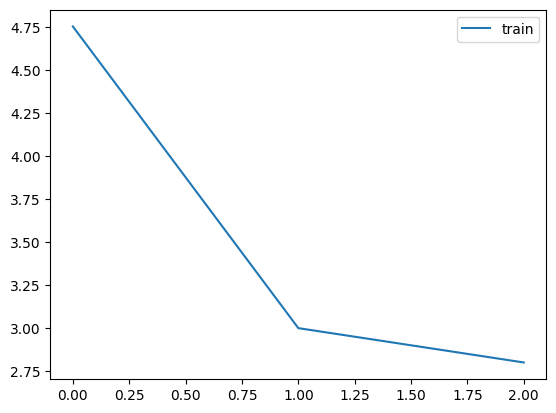

In [77]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:

# mapping back from the outputted rephrased senteence in tokenized form to word form
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
def seq2rephrase(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['rbegin']) and i!=target_word_index['rend']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString


In [ ]:
for i in range(25, 26):
  print(i)
  print("Review:",seq2text(x_tr[i]))
  print("Original rephrase:",seq2rephrase(y_tr[i]))
  print("Predicted rephrase:",decode_sequence(x_tr[i].reshape(1,max_seq_length)))
  print("\n")